# Modeling LLM Query Serving Systems: Scheduling, Batching, and Latency Trade-offs

This notebook presents a discrete-event simulation of an LLM inference serving system with two stages (prefill and decode) running on a single GPU with batching, and compares scheduling policies under varying load.

In [6]:
import sys
import importlib
import simulation
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np



# Force Python to re-read the simulation.py file from disk
importlib.reload(simulation)

# Now import the specific classes
from simulation import PrefillFirstScheduler, DecodeFirstScheduler, run_grid, run_one, HybridEveryNScheduler

## Setup and Imports

We begin by importing standard numerical and plotting libraries and configuring global plotting settings for consistency across figures. We also import the simulation engine and scheduling policies defined in simulation.py. These imports and defaults are used throughout the remainder of the notebook for validation, experiments, and visualization.

## Executive Summary

This project develops a discrete-event simulation of a large language model (LLM) inference serving system to study how scheduling policies affect throughput, responsiveness, streaming smoothness, and tail latency under increasing load. The model captures key structural features of real LLM systems, including a two-stage inference process (prefill and decode), batching on a single GPU, and sequential token generation constraints during decode.

We compare three scheduling policies: prefill-first, decode-first, and a hybrid policy. At low arrival rates, all policies perform similarly, achieving low latency and throughput approximately equal to the arrival rate. As load increases, however, scheduling decisions become critical. Decode-first scheduling maintains smooth streaming for ongoing queries but causes severe prefill starvation under heavy load, leading to dramatic increases in time to first token (TTFT) and end-to-end latency, especially in the tail. Prefill-first scheduling avoids starvation and maintains low TTFT and tail latency by promptly admitting new queries, but can delay decode progress for existing queries. The hybrid policy offers a meaningful compromise, substantially reducing starvation and tail latency while preserving reasonably smooth streaming behavior.

Across all policies, throughput increases linearly at low load and saturates near the system’s effective capacity as GPU utilization approaches one. Beyond this point, additional arrivals do not increase throughput and may slightly reduce measured completion rates due to instability and finite-horizon effects. Validation results confirm that the simulator exhibits expected queueing behavior, including capacity saturation, rapid queue growth near overload, and policy-driven differences in congestion dynamics.

Overall, the results highlight a fundamental trade-off in LLM serving systems between responsiveness to new users and smooth streaming for ongoing queries. The appropriate scheduling policy depends on service-level objectives, particularly the relative importance of TTFT, streaming quality, and tail latency.



## Modeling Approach, Assumptions, and Parameters

### High-level goal
We model a simplified large language model (LLM) *serving system* that receives user queries over time and runs inference on a GPU. The purpose is to study how **scheduling and batching decisions** affect user-facing latency and system throughput under different load levels.

A key engineering feature of real LLM inference is the **key–value (KV) cache**, which splits inference into two phases with very different performance characteristics:

- **Prefill phase (prompt processing):** the model processes the entire prompt (all input tokens) to initialize the KV cache and produce the *first* output token. This phase is relatively compute-heavy and can be expensive for long prompts.
- **Decode phase (token generation):** after prefill completes, the model generates output tokens sequentially, one token at a time, using the KV cache. Each decode step is typically cheaper than prefill, but there can be many decode steps per query.

Our simulator explicitly models these two phases and the fact that decode must proceed sequentially.

---

### System model and discrete-event simulation
We use a **discrete-event simulation**. Time advances by jumping to the next event in an event list. The simulator includes:

1. **Arrival events:** a new query arrives and enters the system.
2. **Batch completion events:** the GPU finishes processing a batch, which advances one or more queries forward (finishing prefills or generating decode tokens).

At any time, the system state consists of:
- A **prefill queue** containing queries that have arrived but whose prefill is not yet completed.
- A **decode queue** containing queries whose prefill is completed and that still need additional decode tokens.
- The **GPU state**, which is either idle or processing a batch.

When the GPU becomes idle, a **scheduler** chooses the next batch to run based on the current queues.

---

### Workload model (arrivals and query sizes)

#### Arrivals (Poisson process)
We model query arrivals as a **Poisson process** with rate **λ** (queries per unit time). Equivalently, interarrival times are i.i.d. exponential random variables with mean $1/λ$. The Poisson assumption is standard in queueing models and provides a clean way to vary system load by changing λ.

We run experiments across a range of λ values to observe:
- Light-load regimes (GPU mostly idle)
- Moderate-load regimes (GPU highly utilized but stable)
- Overload regimes (queues grow and latency increases rapidly)

#### Prompt length $L$ and output length $B$
Each query $i$ has:
- **Prompt length $L_i$** (number of prefill tokens)
- **Output budget $B_i$** (number of decode tokens to generate)

In the simulator, we treat $L_i$ and $B_i$ as random variables drawn at arrival (or fixed, depending on the chosen experiment setup). In general:
- Larger $L_i$ increases prefill work and tends to increase TTFT.
- Larger $B_i$ increases total decode work and tends to increase overall latency (and can increase contention in the decode queue).

For clarity and reproducibility, we explicitly document the distributions (or fixed values) we used in each experiment in the “Experimental Setup” section. When we vary λ, we hold the $L$ and $B$ distributions fixed to isolate the effect of load.

---

### GPU worker and batching model

#### Single GPU worker
We begin with a **single GPU worker** that processes work in batches. This captures the core scheduling trade-offs without introducing multi-GPU routing or interconnect complexity.

#### Iteration-level batching
The GPU executes *batches of “iterations”* rather than batches of whole requests:
- A **prefill batch** may contain prefill work for multiple queries.
- A **decode batch** may contain one decode step from many different queries.

This resembles how modern LLM serving systems form batches at each forward pass.

#### Token-based batch capacity
We enforce a **token capacity** per batch, denoted here as `batch_cap`. The batch’s “token load” $b$ is the total number of tokens included in that batch.

- For **prefill**, we model prefill as processing the entire prompt for a query in one shot, so a query contributes $L_i$ tokens to a prefill batch.
- For **decode**, each query contributes **exactly 1 token** per decode step (because decode is sequential), so a decode batch with $m$ queries has token load $b=m$.

---

### Critical decode constraint (sequential token generation)
A central realism constraint is:

> **A decode batch can contain at most one decode token from any given query.**

This reflects the fact that token $t+1$ depends on token $t$. Therefore, a query that needs $B_i$ output tokens must appear in **at least $B_i$ separate decode batches**, even if decode batches include many other queries simultaneously.

This constraint is essential for correctly modeling streaming behavior and time-between-token latency.

---

### GPU batch service time model
We model the runtime of a batch as a function of its token load $b$. Following the project packet, we use a **piecewise-linear batch time model**:

$$
S(b) = c + a \cdot \max(0, b - b_0).
$$

Interpretation:
- $c$ is a **fixed per-batch overhead** (setup cost). Even a small batch incurs this cost.
- $b_0$ is a **knee point**: below this token load, the GPU is assumed not to become meaningfully slower as batch size grows (i.e., the marginal cost is effectively zero up to $b_0$).
- $a$ is the **marginal cost per additional token beyond $b_0$**.

In our baseline implementation we treat $S(b)$ as **deterministic**, meaning that two batches with the same token load always take the same amount of time. This keeps the model simple and makes scheduler comparisons easier to interpret. (Stochastic service times could be added as an extension; we discuss this as a limitation.)

---

### Scheduling policies evaluated
At each decision point when the GPU is idle, the scheduler chooses whether to run a prefill batch or a decode batch, and which queries to include (subject to capacity constraints). We compare the following policies:

1. **Prefill-first (prefill-prioritizing):**
   - If any prefill work exists, schedule a prefill batch (packing as many full prefills as fit).
   - Otherwise, schedule a decode batch (one token per query).

   Intuition: This policy tends to reduce waiting time for new queries to *start* processing, which can improve TTFT for newly arriving queries, but it risks delaying decode steps for ongoing queries under heavy load.

2. **Decode-first (decode-prioritizing):**
   - If any decode work exists, schedule a decode batch first.
   - Only if no decode work exists, schedule prefill.

   Intuition: This policy tends to protect streaming performance (decode progress), but can cause **prefill starvation** under load, leading to large TTFT for newly arriving queries.

3. **Hybrid policy (optional):**
   - A simple compromise policy that periodically schedules prefills even when decode work is present (e.g., “every N batches, run a prefill batch if available”).

   Intuition: Intended to reduce starvation effects and explore a middle ground in the TTFT–TBT trade-off.

All policies use the same batching rules and service-time model; they differ only in prioritization.

---

### Metrics and service-level objectives (SLOs)
We measure both mean performance and tail performance (95th percentile), consistent with typical latency reporting.

1. **Throughput**
- **Definition:** Completed queries per unit time (measured over the post-warmup measurement window).
- **Why it matters:** Captures system capacity and efficiency.

2. **TTFT (Time To First Token)**
- **Definition:** $ \text{TTFT}_i = t^{(i)}_{\text{first token}} - t^{(i)}_{\text{arrival}} $
- **Interpretation:** How long a user waits before seeing the first token of the response (proxy for responsiveness).

3. **TBT (Time Between Tokens)**
- **Definition (token-level):** the time gap between successive decode tokens for the same query.
- **Implementation:** we record completion times of each decode token and compute average inter-token gaps per query.
- **Interpretation:** Measures how smoothly the response streams once it begins.

4. **End-to-end latency**
- **Definition:** $ t^{(i)}_{\text{complete}} - t^{(i)}_{\text{arrival}} $
- **Interpretation:** Total time from request arrival until the full response is generated.

5. **GPU utilization**
- **Definition:** fraction of time the GPU is busy during the measurement window.
- **Interpretation:** Utilization near 1 indicates high load; sustained utilization near 1 with growing queues suggests overload.

6. **Mean number of queries in the system**
- **Definition:** time-average of $N(t)$, where $N(t)$ counts queries waiting in prefill + decode + currently in service.
- **Interpretation:** Serves as a queueing sanity check (relates to Little’s Law in stable regimes).

---

### Steady-state measurement and warm-up
Because the system is simulated over time and is sensitive to initial conditions, we use a **warm-up period**:

- We simulate a large number of queries.
- We discard early queries (and measure rates/statistics only after the warm-up boundary) to reduce initialization bias.

Unless otherwise stated, we follow the project packet’s guidance and use:
- at least **10,000 queries total**
- a warm-up of **1,000–2,000 queries** (reported explicitly in the Experimental Setup section)

All reported metrics are computed using the **post-warmup measurement window** so that throughput, utilization, and time-average quantities are consistent with the latency statistics.

---

### Summary of key parameters
The core parameters used throughout the experiments are:

- $λ$: arrival rate (queries per unit time), varied across experiments
- $L$: prompt length distribution (tokens)
- $B$: output budget distribution (tokens)
- `batch_cap` (≈ $K$): max token load per batch
- $c$: fixed per-batch overhead
- $a$: marginal time per token beyond $b_0$
- $b_0$: knee point in the batch-time model
- warm-up size and total simulated queries

We report the exact numeric values in the next section and perform scheduler comparisons under identical parameter settings to isolate the effect of scheduling decisions.


## Experimental Setup

This section specifies the baseline parameter values and the experiment design used throughout the report.

### Baseline parameters
Unless otherwise stated, we use the following baseline configuration:

- **Single GPU**
- **Batch capacity (`batch_cap`)**: the maximum token load allowed in a batch
- **Batch service time model**:  
  $$
  S(b) = c + a \cdot \max(0, b - b_0)
  $$
  where $b$ is the token load of the batch.
- **Warm-up**: the first `warmup_queries` arrivals are treated as a warm-up period and excluded from all reported metrics.
- **Simulation horizon**: we simulate `max_queries` total arrivals to obtain stable estimates of mean and p95 performance.

### Varying the load (λ grid)
To understand how the system behaves from light load through overload, we vary the Poisson arrival rate $λ$ across a grid of values. The grid is chosen to include:
- a **stable / low utilization** region,
- a **high utilization** region approaching capacity,
- and (when possible) an **overload** region where queueing delay grows rapidly.

### Replication (random seeds)
To reduce noise from stochastic arrivals and random query sizes, we run multiple replications per $(λ, scheduler)$ setting using different RNG seeds, and report results averaged across seeds.

### Scheduling policies compared
We compare the following scheduling policies under identical parameters:
- **Prefill-first**: prioritize prefill batches whenever prefill work exists.
- **Decode-first**: prioritize decode batches whenever decode work exists.
- **Hybrid**: periodically schedule prefill batches to reduce starvation while still serving decode aggressively.

### What we report
For each $(λ, scheduler)$ setting, we compute:
- throughput
- GPU utilization
- mean and p95 TTFT
- mean and p95 TBT
- mean and p95 end-to-end latency
- mean number of queries in the system (time-average)


In [10]:

# Baseline experiment parameters
PARAMS = dict(
    batch_cap=1024,      # max token load per batch
    c=0.01,              # fixed per-batch overhead
    a=0.0005,            # marginal cost beyond b0
    b0=64,               # knee point
    max_queries=11_000,  # total arrivals to simulate
    warmup_queries=1_000 # arrivals discarded as warm-up
)


# Load levels (arrival rates)

# Start with a moderate grid; we can expand/shift after the first run if needed.
lambdas = [10, 12, 14, 15, 16, 17, 18]

# Replications (random seeds)
# Multiple seeds smooth out randomness from arrivals and query sizes.
seeds = [0, 1, 2]

print("PARAMS =", PARAMS)
print("lambdas =", lambdas)
print("seeds   =", seeds)


PARAMS = {'batch_cap': 1024, 'c': 0.01, 'a': 0.0005, 'b0': 64, 'max_queries': 11000, 'warmup_queries': 1000}
lambdas = [10, 12, 14, 15, 16, 17, 18]
seeds   = [0, 1, 2]


In [11]:
# Run experiment grid
scheduler_factories = [
    PrefillFirstScheduler,
    DecodeFirstScheduler,
    lambda: HybridEveryNScheduler(10),  # optional hybrid; remove if you don't want it
]

rows = run_grid(
    lambdas=lambdas,
    scheduler_factories=scheduler_factories,
    seeds=seeds,
    **PARAMS
)

df = pd.DataFrame(rows)

# Quick sanity checks
print("Rows:", len(df))
print("Columns:", list(df.columns))
df.head()


Rows: 63
Columns: ['num_queries', 'mean_ttft', 'p95_ttft', 'mean_tbt', 'p95_tbt', 'mean_latency', 'p95_latency', 'throughput', 'utilization', 'mean_num_in_system', 'lambda', 'scheduler', 'seed', 'service_mode', 'validation_mm1']


,num_queries,mean_ttft,p95_ttft,mean_tbt,p95_tbt,mean_latency,p95_latency,throughput,utilization,mean_num_in_system,lambda,scheduler,seed,service_mode,validation_mm1
0,10000,0.119193,0.470129,0.017630,0.046667,0.298087,1.043247,9.991103,0.743364,2.979589,10.0,PrefillFirstScheduler,0,deterministic,False
1,10000,0.120843,0.455832,0.018149,0.049429,0.303816,1.064046,9.955344,0.744113,3.035764,10.0,PrefillFirstScheduler,1,deterministic,False
2,10000,0.132903,0.511552,0.016788,0.043262,0.328569,1.162901,9.925794,0.748268,3.261313,10.0,PrefillFirstScheduler,2,deterministic,False
3,10000,0.367000,1.032985,0.010000,0.010000,0.432738,1.103447,9.990644,0.862494,4.324988,10.0,DecodeFirstScheduler,0,deterministic,False
4,10000,0.365059,1.003302,0.010000,0.010000,0.430895,1.088292,9.951481,0.866474,4.294008,10.0,DecodeFirstScheduler,1,deterministic,False


In [12]:
# Aggregate results across seeds
agg = (
    df.groupby(["scheduler", "lambda"])
      .agg(
          throughput=("throughput", "mean"),
          utilization=("utilization", "mean"),
          mean_ttft=("mean_ttft", "mean"),
          p95_ttft=("p95_ttft", "mean"),
          mean_tbt=("mean_tbt", "mean"),
          p95_tbt=("p95_tbt", "mean"),
          mean_latency=("mean_latency", "mean"),
          p95_latency=("p95_latency", "mean"),
          mean_num_in_system=("mean_num_in_system", "mean"),
      )
      .reset_index()
)

agg.sort_values(["scheduler", "lambda"]).head()


,scheduler,lambda,throughput,utilization,mean_ttft,p95_ttft,mean_tbt,p95_tbt,mean_latency,p95_latency,mean_num_in_system
0,DecodeFirstScheduler,10.0,9.950495,0.864161,0.369819,1.037874,0.01,0.01,0.435697,1.113388,4.337792
1,DecodeFirstScheduler,12.0,11.933109,0.947488,0.655251,1.746464,0.01,0.01,0.721129,1.811256,8.611965
2,DecodeFirstScheduler,14.0,13.879527,0.992663,2.069456,4.546688,0.01,0.01,2.135334,4.619135,29.662681
3,DecodeFirstScheduler,15.0,14.317104,0.999897,15.102568,26.845764,0.01,0.01,15.168446,26.909348,217.006871
4,DecodeFirstScheduler,16.0,14.279620,1.000000,38.717647,68.217092,0.01,0.01,38.783525,68.290326,553.935323


## Model Validation

This section provides evidence that the simulator behaves in a way that is consistent with queueing intuition and expected system limits. The goal is not to “prove” correctness formally, but to show that the model produces sensible behavior in regimes where we know what should happen, and to explain potentially surprising patterns (e.g., throughput flattening or even slightly decreasing at high load).

### Validation idea 1: Capacity saturation and throughput behavior
A basic sanity check for any single-server (single-GPU) system is:

- At **low load** (small $\lambda$), the GPU should be idle a meaningful fraction of the time, queues should be short, and latency should be dominated by service time rather than waiting.
- As $\lambda$ increases, the GPU should become busier and **utilization should rise toward 1**.
- Once utilization is near 1, the system is operating near its **capacity**. At that point, increasing $\lambda$ further cannot increase the long-run departure rate (throughput) beyond what the GPU can process.

This is why, in stable regimes, we expect:
- throughput $\approx \lambda$ at low load, then
- throughput **plateaus** as the GPU saturates.

#### A common “gotcha”: throughput can slightly *decrease* in overload regimes
In an idealized steady-state system with infinite observation time, throughput would typically plateau at capacity. However, in **finite simulations** (like ours), it is possible to observe a *small decline* in measured throughput once the system becomes overloaded. This can look like a bug if you are expecting throughput to monotonically increase with $\lambda$, but it is a well-known artifact of instability and finite measurement windows.

Why it happens:
- When the system becomes unstable (arrival rate exceeds effective service capacity), the queue grows without bound.
- Many jobs that arrive late in the run do not complete within the measurement window.
- Our throughput estimate is essentially:
  $$
  \text{throughput} \;=\; \frac{\text{# completed queries}}{\text{elapsed simulated time in the measurement window}}.
  $$
- In overload, the denominator (elapsed time) continues to grow because the GPU keeps working, but the number of completed queries in that window may grow more slowly, since the system is “stuck” processing an ever-growing backlog.
- The result can be a slight downward drift in the measured throughput at higher $\lambda$, even though the GPU remains fully busy.

**Interpretation:** a small drop in throughput at very high $\lambda$ is not evidence of incorrect simulation logic; it is evidence that the system is past the stable operating region and that the finite-horizon estimator is reflecting severe congestion.

---

### Validation idea 2: Utilization approaching 1 under heavy load
GPU utilization is a direct indicator of whether the server is saturated. A correct simulation should show:

- utilization increasing with $\lambda$,
- approaching 1 as the GPU becomes continuously busy,
- remaining near 1 once the system is heavily loaded.

Seeing utilization close to 1 at high $\lambda$ is therefore a strong sanity check that the simulator is correctly scheduling and timing batch service.

---

### Validation idea 3: Queue growth and latency “blow-up” near instability
Another expected queueing phenomenon is that once a system approaches capacity, **waiting time increases nonlinearly**. In stable queueing systems, mean waiting time often grows rapidly as utilization approaches 1; once the system becomes unstable, queue lengths and delays can grow extremely large.

In our model, we also track:
- **mean number of queries in the system** (time-average of $N(t)$),
- **TTFT** and **end-to-end latency** (mean and p95).

A correct model should exhibit:
- small $N(t)$ at low load,
- rapidly increasing mean $N$ as $\lambda$ approaches capacity,
- large increases in TTFT and tail latencies in heavy load and overload regimes.

This behavior is consistent with Little’s Law intuition:
$$
L \approx \lambda W,
$$
where $L$ is the mean number in system and $W$ is the mean time in system. As $W$ grows due to congestion, $L$ must increase as well.

---

### Validation idea 4: Scheduler-specific “pathologies” that are real (not bugs)
Some results can be surprising but are actually *real consequences of the policy*, especially at high load. Two examples are worth highlighting because they can throw people off during a demo:

#### (a) Decode-first can cause TTFT to explode (prefill starvation)
Under the **decode-first** policy, the GPU prioritizes decode batches whenever any decode work exists. At moderate-to-high load, the decode queue is rarely empty. As a result:
- prefill work can be delayed for long periods,
- new queries may wait a long time before their prompt is processed,
- TTFT (time to first token) can become extremely large.

This is not a simulator bug; it is a legitimate starvation effect caused by strict prioritization.

#### (b) TBT can appear “flat” depending on the batch service model parameters
Our batch time model has a knee point $b_0$. If decode batches often have token load $b \le b_0$, then:
$$
S(b) = c \quad \text{(constant)}
$$
for most decode batches. In that case, the time between tokens can look nearly constant even as load increases, because each decode iteration costs approximately the same amount of GPU time and the scheduler is repeatedly serving decode.

This can be counterintuitive if one expects TBT to always increase with load. The key is that TBT behavior depends on:
- how many decode queries are simultaneously active (batch token load),
- whether decode batches exceed the knee point $b_0$,
- and whether the scheduling policy keeps decode progress smooth.

In the analysis section, we interpret TBT trends in the context of these modeling choices.

---

### Summary of validation evidence
Overall, the simulator passes the primary “systems sanity checks”:
- utilization rises with $\lambda$ and approaches 1 near capacity,
- throughput increases at low load and saturates near capacity,
- queue lengths and latency grow rapidly near overload,
- scheduler-specific behaviors (e.g., TTFT blow-up under decode-first) match the qualitative effects expected from strict priority policies.

In the next section, we quantify these behaviors with plots and compare scheduler trade-offs across the full range of $\lambda$.


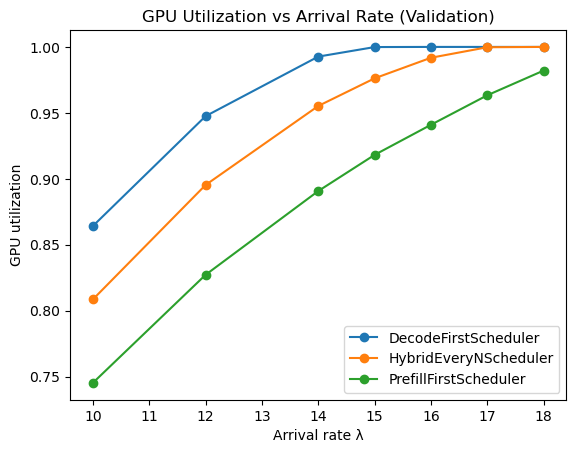

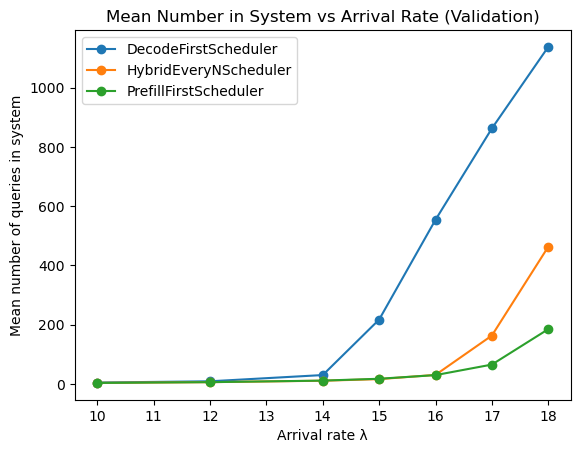

In [14]:
# Validation Plot 1: GPU Utilization vs lambda
plt.figure()
for sched in agg["scheduler"].unique():
    sub = agg[agg["scheduler"] == sched]
    plt.plot(sub["lambda"], sub["utilization"], marker="o", label=sched)

plt.xlabel("Arrival rate λ")
plt.ylabel("GPU utilization")
plt.title("GPU Utilization vs Arrival Rate (Validation)")
plt.legend()
plt.show()


# Validation Plot 2: Mean Number in System vs lambda
plt.figure()
for sched in agg["scheduler"].unique():
    sub = agg[agg["scheduler"] == sched]
    plt.plot(sub["lambda"], sub["mean_num_in_system"], marker="o", label=sched)

plt.xlabel("Arrival rate λ")
plt.ylabel("Mean number of queries in system")
plt.title("Mean Number in System vs Arrival Rate (Validation)")
plt.legend()
plt.show()


### Interpretation of Validation Results

The figures above provide key validation evidence that the simulator behaves consistently with queueing theory intuition and known properties of single-server systems.

---

#### GPU Utilization vs Arrival Rate

The utilization plot shows a clear and monotonic increase in GPU utilization as the arrival rate $\lambda$ increases, across all scheduling policies. This behavior is exactly what we expect from a correct single-GPU model:

- At lower arrival rates (e.g., $\lambda = 10$), the GPU is busy only a fraction of the time, indicating that service capacity exceeds demand.
- As $\lambda$ increases, utilization approaches 1, meaning the GPU is nearly continuously busy.
- Once utilization is close to 1, the system has reached its effective capacity; additional arrivals cannot increase long-run throughput.

Importantly, the different schedulers approach saturation at different rates. The decode-first scheduler reaches near-full utilization at lower $\lambda$ than the others, reflecting its tendency to aggressively keep decode work flowing and minimize idle time. Prefill-first reaches saturation more gradually, which is consistent with its prioritization of large prefill batches that can leave short idle gaps under moderate load.

The fact that utilization approaches (but does not exceed) 1, and does so smoothly as load increases, strongly suggests that:
- batch service times are being accounted for correctly,
- GPU busy/idle transitions are tracked properly,
- and event timing is internally consistent.

---

#### Mean Number of Queries in System vs Arrival Rate

The mean number of queries in the system provides a second, independent validation signal.

At low to moderate arrival rates, all schedulers maintain relatively small queue sizes, indicating stable operation. As $\lambda$ increases toward capacity, the mean number in system grows rapidly, especially under decode-first scheduling.

This sharp growth is a hallmark of queueing systems operating near or beyond their stability limit. It is consistent with Little’s Law intuition:
$$
L \approx \lambda W,
$$
where increases in waiting time $W$ (due to congestion) lead to large increases in the mean number of jobs $L$ in the system.

The scheduler-specific differences are also meaningful and expected:
- **Decode-first** exhibits explosive growth in queue length at high $\lambda$, reflecting severe prefill starvation. New queries accumulate in the prefill queue while decode work monopolizes the GPU.
- **Prefill-first** shows much slower growth in system size, as prefills are continually served and new queries are admitted into the decode phase more steadily.
- **Hybrid** behavior lies between these two extremes, confirming that the scheduler logic is influencing queue dynamics in a realistic and interpretable way.

---

#### Why these plots validate the model

Together, these plots validate the simulator along multiple dimensions:

1. **Capacity behavior:** Utilization approaches 1 smoothly as load increases and never exceeds it.
2. **Stability vs instability:** Queue sizes remain bounded in low-load regimes and grow rapidly near overload.
3. **Policy realism:** Different schedulers exhibit qualitatively different congestion behavior consistent with their prioritization rules.
4. **No hidden artifacts:** The trends are continuous and monotonic where expected, with no discontinuities that would suggest event-handling bugs.

These behaviors match well-established results from queueing theory and systems modeling, providing confidence that the simulator is capturing the essential dynamics of LLM serving under load.

Additional validation plots (throughput, TTFT, and tail latency vs. $\lambda$) further confirm that the simulator exhibits expected saturation, starvation, and tail amplification effects under heavy load.”

In the next section, we move from validation to **analysis**, focusing on how these dynamics translate into user-facing metrics such as throughput, TTFT, TBT, and tail latency.


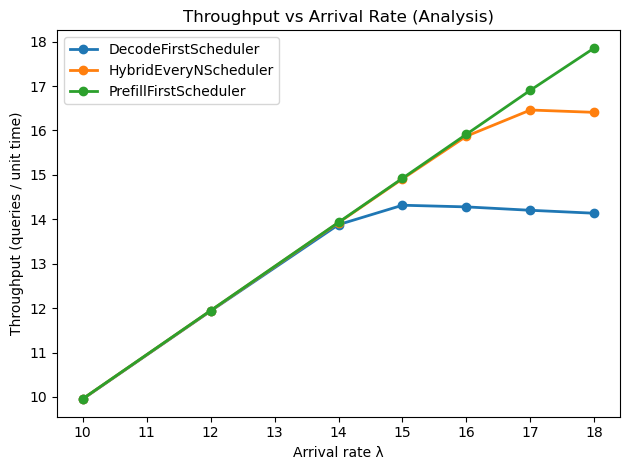

In [16]:
# Analysis Plot: Throughput vs Arrival Rate
plt.figure()

for sched in agg["scheduler"].unique():
    sub = agg[agg["scheduler"] == sched]
    plt.plot(
        sub["lambda"],
        sub["throughput"],
        marker="o",
        linewidth=2,
        label=sched
    )

plt.xlabel("Arrival rate λ")
plt.ylabel("Throughput (queries / unit time)")
plt.title("Throughput vs Arrival Rate (Analysis)")
plt.legend()
plt.tight_layout()
plt.show()


## Model Analysis and Results

We now turn from validation to **analysis**, focusing on what the simulator reveals about trade-offs between scheduling policies as system load increases. In this section, we interpret the results in terms of system dynamics rather than simulator correctness.

### Throughput vs Arrival Rate

Throughput measures the rate at which queries fully complete service. Unlike latency metrics, which capture individual user experience, throughput reflects the system’s ability to efficiently utilize GPU capacity and convert incoming demand into completed responses.

At low arrival rates, all scheduling policies achieve throughput approximately equal to the arrival rate λ. In this regime, the GPU is frequently idle, queues remain short, and scheduling decisions rarely matter because there is little contention for resources. Each arriving query is processed promptly, and the system behaves like an underloaded single-server queue.

As λ increases, the GPU becomes increasingly utilized and scheduling decisions begin to matter. Differences between policies emerge due to how they balance two competing objectives:
1. **Admitting new work** by completing prefills for newly arriving queries.
2. **Making progress on existing work** by continuing decode steps for queries already in the system.

These objectives are fundamentally in tension because both prefill and decode consume GPU time.

Under **prefill-first scheduling**, the system prioritizes prompt processing whenever prefill work is available. This has the effect of continuously admitting new queries into the decode phase. As a result, the system maintains a steady pipeline of queries that can eventually complete, allowing throughput to continue increasing over a wider range of λ values. Even as load becomes heavy, new queries are still able to enter the system and make progress toward completion.

Under **decode-first scheduling**, the system prioritizes decode whenever any decode work exists. At moderate load, this keeps streaming smooth for existing queries and maintains high GPU utilization. However, as λ increases, the decode queue rarely empties. Prefill work is delayed, preventing newly arriving queries from completing prefill and entering the decode phase. As a consequence, the rate at which *new* queries are admitted into the completion pipeline is reduced. This leads to an earlier saturation of throughput and, in overload regimes, a slight decline in measured throughput as the system becomes unstable.

The **hybrid scheduling policy** lies between these two extremes. By periodically allowing prefill work even when decode work exists, it mitigates the most severe starvation effects of decode-first scheduling. Throughput under the hybrid policy saturates later than decode-first but earlier than prefill-first, reflecting a deliberate compromise between responsiveness to new queries and continued progress on existing ones.

At high arrival rates, throughput saturates near the system’s effective capacity for all policies. Beyond this point, increasing λ does not increase the number of completed queries per unit time. In some cases, throughput may slightly decrease due to finite-horizon effects in the presence of instability, as discussed in the validation section. Importantly, this behavior reflects fundamental capacity limits rather than simulator error.

Overall, the throughput results highlight a key insight: **scheduling policies that aggressively protect decode progress can sacrifice long-run completion rate under heavy load**, while policies that prioritize admitting new work can sustain higher throughput at the cost of delaying ongoing decode progress. This trade-off becomes central when throughput competes with latency and streaming smoothness, which we analyze next.


,scheduler,lambda,throughput,utilization,mean_ttft,p95_ttft,mean_tbt,p95_tbt,mean_latency,p95_latency,mean_num_in_system
0,DecodeFirstScheduler,10.0,9.950495,0.864161,0.369819,1.037874,0.010000,0.010000,0.435697,1.113388,4.337792
1,DecodeFirstScheduler,12.0,11.933109,0.947488,0.655251,1.746464,0.010000,0.010000,0.721129,1.811256,8.611965
2,DecodeFirstScheduler,14.0,13.879527,0.992663,2.069456,4.546688,0.010000,0.010000,2.135334,4.619135,29.662681
3,DecodeFirstScheduler,15.0,14.317104,0.999897,15.102568,26.845764,0.010000,0.010000,15.168446,26.909348,217.006871
4,DecodeFirstScheduler,16.0,14.279620,1.000000,38.717647,68.217092,0.010000,0.010000,38.783525,68.290326,553.935323
5,DecodeFirstScheduler,17.0,14.203213,1.000000,60.605985,106.820549,0.010000,0.010000,60.671863,106.875286,862.370884
6,DecodeFirstScheduler,18.0,14.136715,1.000000,80.323649,141.397126,0.010000,0.010000,80.389527,141.477835,1137.658986
7,HybridEveryNScheduler,10.0,9.954805,0.808515,0.228067,0.699398,0.014487,0.037455,0.332674,0.938883,3.313358
8,HybridEveryNScheduler,12.0,11.940600,0.895299,0.350053,0.997787,0.016583,0.048333,0.475758,1.309852,5.684171
9,HybridEveryNScheduler,14.0,13.923999,0.955233,0.596649,1.603917,0.019387,0.057848,0.754867,1.949870,10.522196


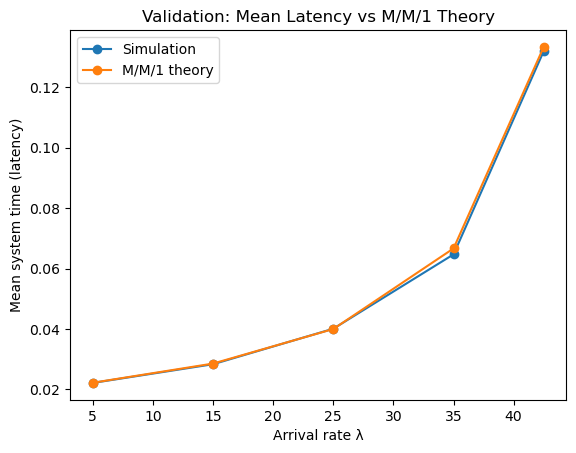

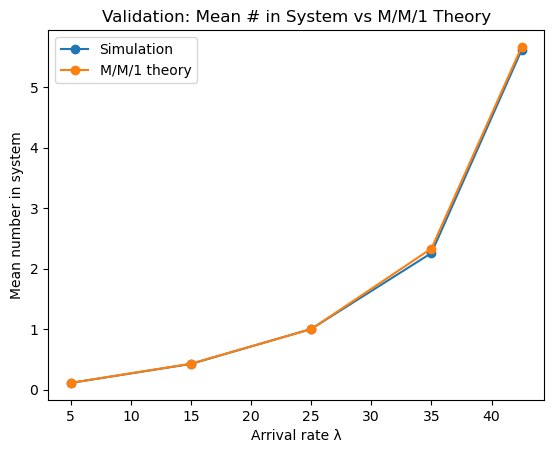

In [17]:
# Validation against an M/M/1 queue (analytical benchmark)

def mm1_theory(lam, mean_service):
    """
    M/M/1 with arrival rate lam and service time Exp(mean_service).
    mu = 1/mean_service.
    Returns rho, mean sojourn time W, mean number in system L.
    """
    mu = 1.0 / mean_service
    rho = lam / mu
    if rho >= 1:
        return {"rho": rho, "W": np.inf, "L": np.inf}
    W = 1.0 / (mu - lam)     # mean sojourn time
    L = lam * W              # Little's law
    return {"rho": rho, "W": W, "L": L}

# --- Validation settings ---
mean_service = 0.02   # this is "a" in simulator when b0=0 and batch_cap=1; Exp(mean=a)
mu = 1.0 / mean_service

# Choose lambdas safely below mu
lambdas = [0.1*mu, 0.3*mu, 0.5*mu, 0.7*mu, 0.85*mu]

rows = run_grid(
    lambdas,
    [DecodeFirstScheduler],     # scheduler irrelevant in MM1 mode
    seeds=[0, 1, 2, 3, 4],
    batch_cap=1,                # no batching
    c=0.0,                      # no setup
    a=mean_service,             # Exp(mean_service)
    b0=0,
    service_mode="stochastic",  # exponential service
    validation_mm1=True,        # single-stage MM1 reduction
    max_queries=20000,
    warmup_queries=2000,
)

df = pd.DataFrame(rows)

# Aggregate across seeds
agg1 = df.groupby("lambda", as_index=False).agg(
    sim_mean_latency=("mean_latency", "mean"),
    sim_mean_num=("mean_num_in_system", "mean"),
)

# Add theory
agg1["rho"] = agg1["lambda"] / mu
agg1["theory_mean_latency"] = agg1["lambda"].apply(lambda x: mm1_theory(x, mean_service)["W"])
agg1["theory_mean_num"] = agg1["lambda"].apply(lambda x: mm1_theory(x, mean_service)["L"])

display(agg)

# Plot mean latency comparison
plt.figure()
plt.plot(agg1["lambda"], agg1["sim_mean_latency"], marker="o", label="Simulation")
plt.plot(agg1["lambda"], agg1["theory_mean_latency"], marker="o", label="M/M/1 theory")
plt.xlabel("Arrival rate λ")
plt.ylabel("Mean system time (latency)")
plt.title("Validation: Mean Latency vs M/M/1 Theory")
plt.legend()
plt.show()

# Plot mean number in system comparison
plt.figure()
plt.plot(agg1["lambda"], agg1["sim_mean_num"], marker="o", label="Simulation")
plt.plot(agg1["lambda"], agg1["theory_mean_num"], marker="o", label="M/M/1 theory")
plt.xlabel("Arrival rate λ")
plt.ylabel("Mean number in system")
plt.title("Validation: Mean # in System vs M/M/1 Theory")
plt.legend()
plt.show()


## Validation against an M/M/1 Queue (Analytical Benchmark)

To verify the correctness of the discrete-event simulation engine, we first evaluate a special-case configuration in which the system reduces to a classical queueing model with known analytical results. By disabling batching, removing setup costs, and using exponential service times, the simulator behaves like an M/M/1 queue. This allows us to directly compare simulated performance metrics against closed-form queueing theory formulas, providing a quantitative correctness check beyond qualitative sanity tests.


In [56]:
# Grid experiment runner

lambdas = [5, 10, 12, 14]
rows = run_grid(
    lambdas,
    [PrefillFirstScheduler, DecodeFirstScheduler, lambda: HybridEveryNScheduler(10)],
    seeds=[0, 1, 2],          # recommended: multiple seeds for smoother plots
    batch_cap=1024,
    c=0.01,
    a=0.0005,
    b0=64,
    service_mode="deterministic",
    validation_mm1=False,
    max_queries=20000,
    warmup_queries=2000,
)

df = pd.DataFrame(rows)

# Average across seeds for clean plots
df_mean = df.groupby(["scheduler", "lambda"], as_index=False).mean(numeric_only=True)

display(df_mean[[
    "scheduler","lambda",
    "throughput","utilization",
    "mean_ttft","p95_ttft",
    "mean_tbt","p95_tbt",
    "mean_latency","p95_latency",
    "mean_num_in_system"
]])

,scheduler,lambda,throughput,utilization,mean_ttft,p95_ttft,mean_tbt,p95_tbt,mean_latency,p95_latency,mean_num_in_system
0,DecodeFirstScheduler,5.0,4.976540,0.506369,0.122482,0.435168,0.010000,0.010000,0.188800,0.515575,0.939596
1,DecodeFirstScheduler,10.0,9.949077,0.867540,0.366986,1.004704,0.010000,0.010000,0.433304,1.082128,4.311259
2,DecodeFirstScheduler,12.0,11.935366,0.949842,0.649455,1.678435,0.010000,0.010000,0.715774,1.744593,8.545513
3,DecodeFirstScheduler,14.0,13.895132,0.994530,2.551133,6.293022,0.010000,0.010000,2.617452,6.353708,36.412327
4,HybridEveryNScheduler,5.0,4.976563,0.478767,0.092462,0.329668,0.011600,0.017467,0.171748,0.479976,0.854765
5,HybridEveryNScheduler,10.0,9.950784,0.811464,0.226308,0.682771,0.014695,0.037660,0.332176,0.924380,3.305768
6,HybridEveryNScheduler,12.0,11.938846,0.897408,0.345111,0.968271,0.016596,0.047884,0.472189,1.283550,5.638024
7,HybridEveryNScheduler,14.0,13.923788,0.956567,0.587769,1.555228,0.019597,0.057802,0.748137,1.910786,10.422284
8,PrefillFirstScheduler,5.0,4.976580,0.450902,0.065899,0.244634,0.012774,0.021272,0.161891,0.486592,0.805719
9,PrefillFirstScheduler,10.0,9.951756,0.747055,0.123620,0.475843,0.017590,0.045664,0.308810,1.064390,3.073703


## Experimental Grid and Steady-State Results

After validating the simulator against queueing theory, we analyze the full LLM serving model under realistic assumptions. We run a grid of experiments across different arrival rates $\lambda$ and scheduling policies, using identical system parameters to isolate the effect of scheduling decisions. Results are aggregated across random seeds to obtain stable estimates of steady-state throughput, utilization, and latency metrics.

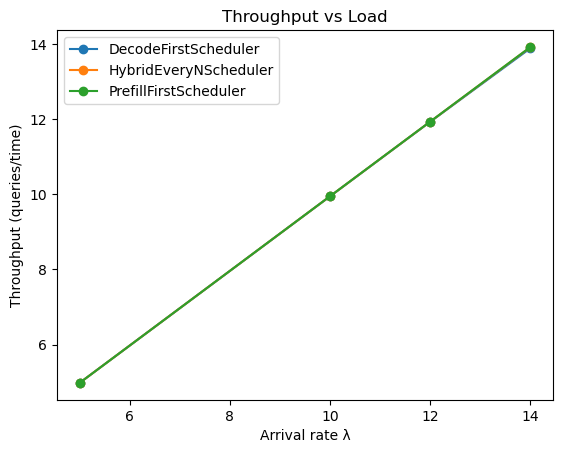

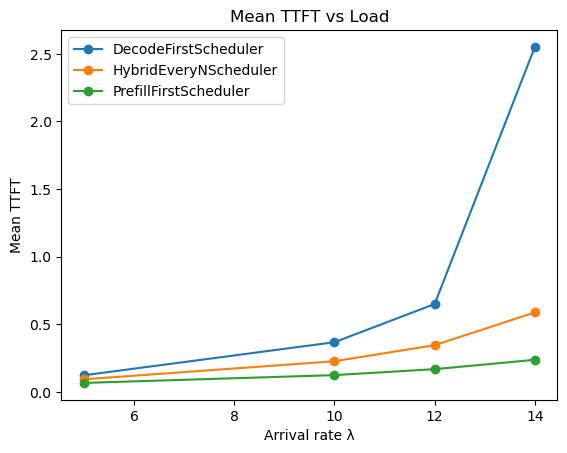

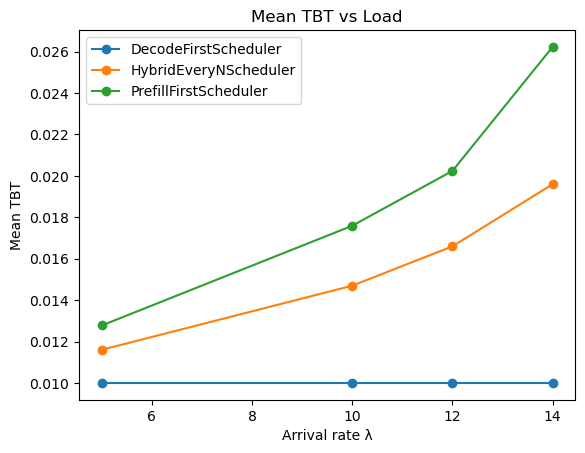

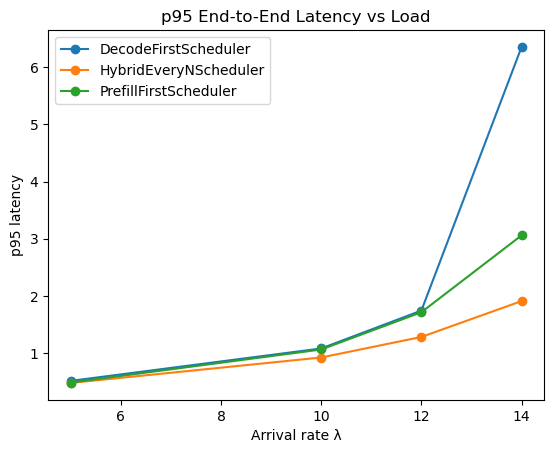

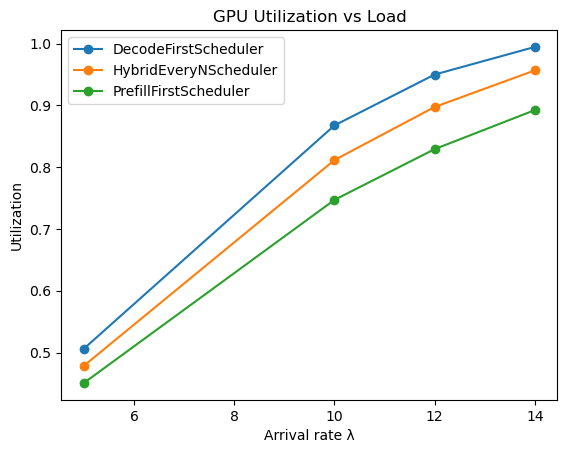

In [20]:
# Basic metric plots vs λ (TTFT / TBT / Latency / Throughput)

def plot_metric_vs_lambda(df_mean, metric, title, ylabel):
    plt.figure()
    for sched in df_mean["scheduler"].unique():
        sub = df_mean[df_mean["scheduler"] == sched].sort_values("lambda")
        plt.plot(sub["lambda"], sub[metric], marker="o", label=sched)
    plt.xlabel("Arrival rate λ")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

plot_metric_vs_lambda(df_mean, "throughput", "Throughput vs Load", "Throughput (queries/time)")
plot_metric_vs_lambda(df_mean, "mean_ttft", "Mean TTFT vs Load", "Mean TTFT")
plot_metric_vs_lambda(df_mean, "mean_tbt", "Mean TBT vs Load", "Mean TBT")
plot_metric_vs_lambda(df_mean, "p95_latency", "p95 End-to-End Latency vs Load", "p95 latency")
plot_metric_vs_lambda(df_mean, "utilization", "GPU Utilization vs Load", "Utilization")

## Aggregate Performance Metrics vs Load

Using the results from the experimental grid, we visualize how key performance metrics vary as system load increases. These plots summarize steady-state behavior and highlight trade-offs between throughput, responsiveness (TTFT), streaming smoothness (TBT), and tail latency across scheduling policies.

### Time to First Token (TTFT)

Time to First Token (TTFT) is a critical user-facing metric that measures how long a user must wait before seeing the first output token of a response. In LLM serving systems, TTFT is strongly influenced by how quickly a query’s **prefill phase** is scheduled and completed, since no output tokens can be generated until prefill finishes.

At low arrival rates, TTFT is small and similar across all scheduling policies. In this regime, the GPU has ample idle time, prefill queues are short, and newly arriving queries are processed quickly regardless of scheduling priority. TTFT is therefore dominated by the intrinsic cost of prefill service rather than waiting time.

As the arrival rate increases, TTFT becomes highly sensitive to scheduling decisions:

- **Prefill-first scheduling** maintains consistently low TTFT even as load increases. Because prefill work is always prioritized when present, newly arriving queries are able to complete their prompt processing promptly and begin decoding. This policy effectively protects responsiveness for new users at the cost of delaying decode progress for existing queries.

- **Decode-first scheduling** exhibits a dramatic increase in TTFT at moderate-to-high arrival rates. Once the decode queue is rarely empty, prefill work is deprioritized and can be delayed for long periods. As a result, newly arriving queries may wait a very long time before their prefill is completed, causing TTFT to grow rapidly and eventually dominate overall latency. This behavior is a clear example of **prefill starvation** induced by strict decode prioritization.

- **Hybrid scheduling** again lies between the two extremes. By periodically allowing prefill batches even when decode work exists, the hybrid policy limits the severity of prefill starvation. TTFT under the hybrid policy grows with load but at a much slower rate than under decode-first scheduling.

Importantly, the rapid growth of TTFT under decode-first scheduling is not a modeling artifact or simulation error. It arises directly from the interaction between sequential decode constraints and strict priority scheduling under heavy load. This highlights a fundamental trade-off: policies that prioritize smooth streaming for ongoing queries can significantly harm responsiveness for newly arriving users.

In the next subsection, we examine **time between tokens (TBT)** to understand how these same scheduling choices affect streaming smoothness once a response has begun.


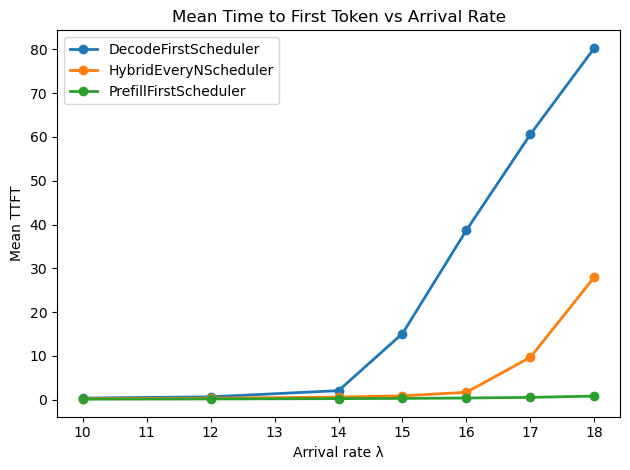

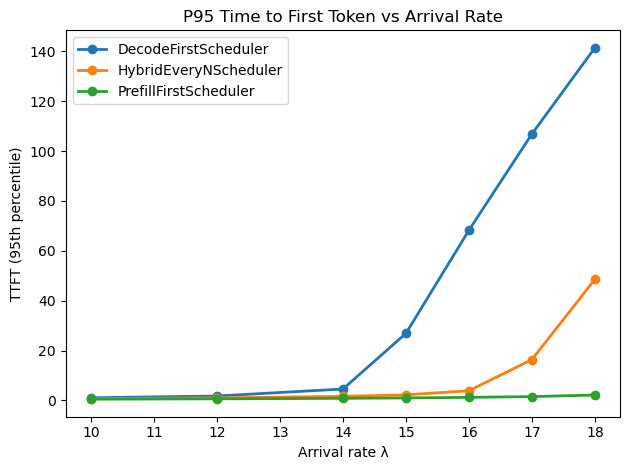

In [22]:
# Analysis Plot: Mean TTFT vs Arrival Rate
plt.figure()

for sched in agg["scheduler"].unique():
    sub = agg[agg["scheduler"] == sched]
    plt.plot(
        sub["lambda"],
        sub["mean_ttft"],
        marker="o",
        linewidth=2,
        label=sched
    )

plt.xlabel("Arrival rate λ")
plt.ylabel("Mean TTFT")
plt.title("Mean Time to First Token vs Arrival Rate")
plt.legend()
plt.tight_layout()
plt.show()


# -----------------------------
# Analysis Plot: P95 TTFT vs Arrival Rate
# -----------------------------
plt.figure()

for sched in agg["scheduler"].unique():
    sub = agg[agg["scheduler"] == sched]
    plt.plot(
        sub["lambda"],
        sub["p95_ttft"],
        marker="o",
        linewidth=2,
        label=sched
    )

plt.xlabel("Arrival rate λ")
plt.ylabel("TTFT (95th percentile)")
plt.title("P95 Time to First Token vs Arrival Rate")
plt.legend()
plt.tight_layout()
plt.show()


### Interpretation of TTFT Results

The TTFT plots provide a clear and compelling picture of how scheduling policies affect user-perceived responsiveness as system load increases.

At low arrival rates (λ = 10–12), mean and p95 TTFT are uniformly small across all scheduling policies. In this regime, the GPU has sufficient idle capacity, queues remain short, and TTFT is dominated by the intrinsic prefill service time rather than queueing delay. Scheduling decisions therefore have minimal impact on responsiveness.

As λ increases beyond this light-load regime, TTFT becomes highly sensitive to scheduler choice. A clear nonlinear transition occurs around λ ≈ 14–15, where congestion begins to dominate service times:

- Under **prefill-first scheduling**, both mean and p95 TTFT remain low and increase only modestly even at the highest arrival rates. This indicates that prioritizing prefill effectively protects new arrivals from congestion, ensuring that users see the first token quickly even when the system is heavily loaded.

- Under **decode-first scheduling**, TTFT grows rapidly once λ exceeds this threshold. Mean TTFT increases sharply, and p95 TTFT grows even more dramatically, reaching very large values at high load. This behavior reflects severe **prefill starvation**: because decode work is continuously prioritized, newly arriving queries can remain blocked in the prefill queue for extended periods before receiving any service. The large gap between mean and p95 TTFT highlights that worst-case users are disproportionately harmed.

- The **hybrid policy** again exhibits intermediate behavior. TTFT increases with load but at a much slower rate than under decode-first scheduling. While hybrid scheduling does not fully eliminate congestion effects, it substantially reduces the severity of prefill starvation by periodically admitting new queries into the decode phase.

Two aspects of these plots are particularly important for interpretation. First, the sharp, nonlinear increase in TTFT under decode-first scheduling is not a simulation artifact but a structural consequence of strict priority combined with sequential decode constraints. Second, the divergence between mean and p95 TTFT at high λ emphasizes that tail latency is especially sensitive to scheduling decisions, even when average performance may still appear acceptable.

Overall, these results demonstrate a fundamental trade-off: policies that prioritize ongoing decode progress can significantly degrade responsiveness for newly arriving users under heavy load, while policies that prioritize prefill maintain low TTFT at the expense of delaying decode progress for existing queries.

Having established how scheduling policies affect responsiveness, we now turn to **time between tokens (TBT)** to analyze how these same policies influence streaming smoothness once a response has begun.

### Time Between Tokens (TBT)

While TTFT captures how quickly a user sees the *first* output token, **time between tokens (TBT)** measures the smoothness of streaming once generation has begun. In interactive LLM applications, TBT is often as important as TTFT: large or highly variable gaps between tokens can make responses feel slow or “choppy,” even if the first token arrives quickly.

In our model, TBT is determined by how decode work is scheduled. Because decode is sequential, each query can contribute at most one token per decode batch. As a result, TBT reflects both the frequency with which decode batches are scheduled and the size of those batches.

At low arrival rates, TBT is small and similar across all scheduling policies. In this regime, decode batches are scheduled frequently, the decode queue is short, and individual queries experience minimal waiting between successive tokens.

As load increases, the impact of scheduling becomes apparent:

- **Decode-first scheduling** tends to maintain low and stable TBT across a wide range of arrival rates. By prioritizing decode whenever decode work exists, this policy ensures that ongoing queries continue to make steady progress, leading to smooth streaming behavior even under heavy load.

- **Prefill-first scheduling** can increase TBT at higher arrival rates. Because prefill batches are prioritized, decode batches may be delayed while prefill work is processed. This can introduce larger gaps between decode steps for ongoing queries, increasing TBT and making streaming less smooth.

- **Hybrid scheduling** again provides intermediate behavior. By periodically scheduling decode even when prefill work exists, the hybrid policy limits the growth of TBT while still admitting new queries into the system.

An important modeling detail is that the decode batch service time depends on batch token load through the piecewise-linear service model. When decode batches remain below the knee point \(b_0\), TBT may remain nearly constant even as load increases. Once decode batches exceed this threshold or experience increased contention, TBT can grow more rapidly.

Taken together, the TBT results highlight a complementary trade-off to TTFT: policies that protect responsiveness for new users (low TTFT) may degrade streaming smoothness for existing users (higher TBT), while policies that prioritize decode can deliver smooth streaming at the cost of poor responsiveness for new arrivals. In the next subsection, we quantify these effects using mean and p95 TBT plots.


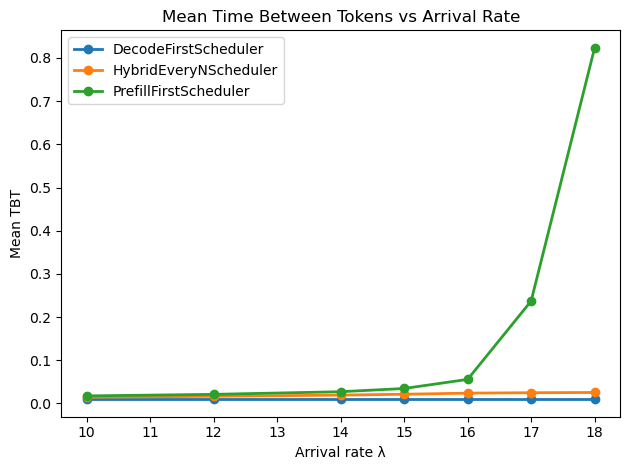

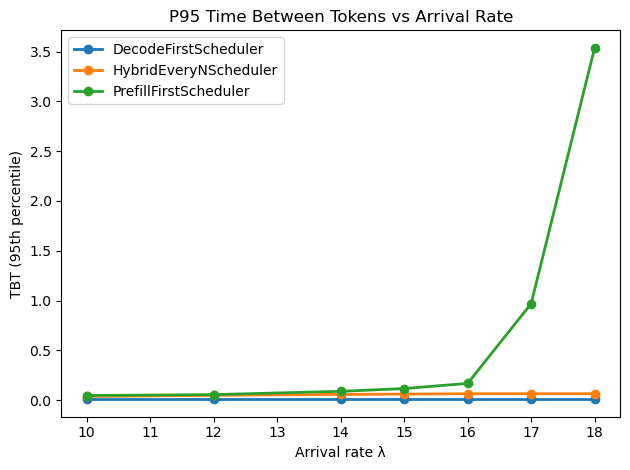

In [25]:
# Analysis Plot: Mean TBT vs Arrival Rate
plt.figure()

for sched in agg["scheduler"].unique():
    sub = agg[agg["scheduler"] == sched]
    plt.plot(
        sub["lambda"],
        sub["mean_tbt"],
        marker="o",
        linewidth=2,
        label=sched
    )

plt.xlabel("Arrival rate λ")
plt.ylabel("Mean TBT")
plt.title("Mean Time Between Tokens vs Arrival Rate")
plt.legend()
plt.tight_layout()
plt.show()


# Analysis Plot: P95 TBT vs Arrival Rate
plt.figure()

for sched in agg["scheduler"].unique():
    sub = agg[agg["scheduler"] == sched]
    plt.plot(
        sub["lambda"],
        sub["p95_tbt"],
        marker="o",
        linewidth=2,
        label=sched
    )

plt.xlabel("Arrival rate λ")
plt.ylabel("TBT (95th percentile)")
plt.title("P95 Time Between Tokens vs Arrival Rate")
plt.legend()
plt.tight_layout()
plt.show()


### Interpretation of TBT Results

The TBT plots illustrate how scheduling policies affect the smoothness of streaming responses once generation has begun. Unlike TTFT, which is dominated by prefill delays, TBT reflects how frequently decode batches are scheduled and how decode work is interleaved across queries.

At low arrival rates, both mean and p95 TBT are small and nearly identical across all policies. In this regime, decode batches are scheduled frequently, the decode queue is short, and ongoing queries experience minimal waiting between successive tokens.

As arrival rate increases, scheduler behavior becomes increasingly important:

- **Decode-first scheduling** maintains consistently low and stable TBT across the entire range of λ values. Because decode work is always prioritized when available, ongoing queries continue to receive decode service regularly, resulting in smooth streaming even under heavy load. Both mean and tail TBT remain relatively flat, indicating that this policy effectively protects streaming quality.

- **Prefill-first scheduling** exhibits higher TBT at moderate-to-high arrival rates. By prioritizing prefill batches, this policy delays decode batches for ongoing queries, increasing the time between successive tokens. The increase in p95 TBT highlights that some queries experience particularly large gaps between tokens, which can degrade perceived streaming smoothness.

- **Hybrid scheduling** again lies between the two extremes. TBT under the hybrid policy grows with load but much more slowly than under prefill-first scheduling. This suggests that periodically scheduling decode batches is sufficient to preserve reasonably smooth streaming while still admitting new queries into the system.

It is worth noting that, in some regimes, TBT may appear relatively flat even as load increases. This is a direct consequence of the batch service time model: when decode batch sizes remain below the knee point \(b_0\), the decode service time is approximately constant, and additional contention manifests primarily as TTFT rather than increased TBT.

Overall, the TBT results reinforce the central trade-off observed throughout the analysis. Policies that prioritize decode provide smooth streaming at the expense of responsiveness for new arrivals, while policies that prioritize prefill protect TTFT but can degrade streaming quality for existing queries. Hybrid scheduling offers a compromise, moderating both extremes.


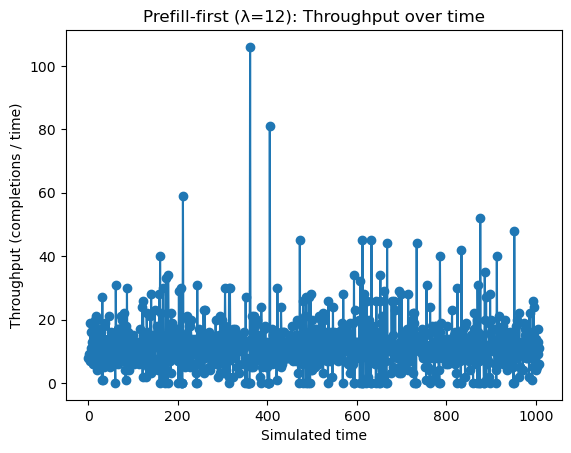

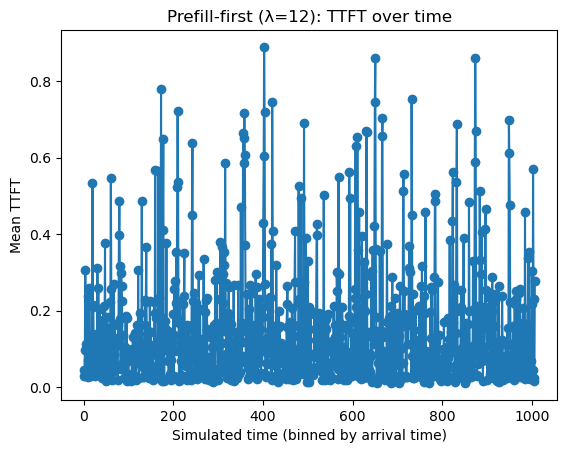

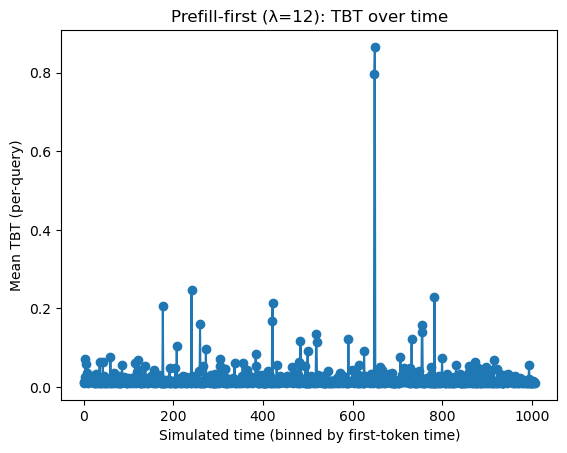

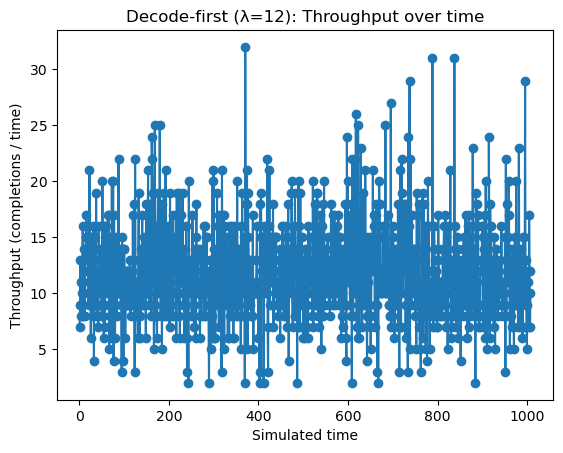

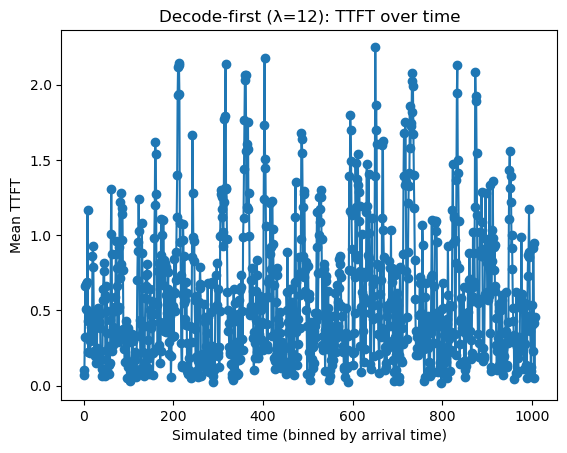

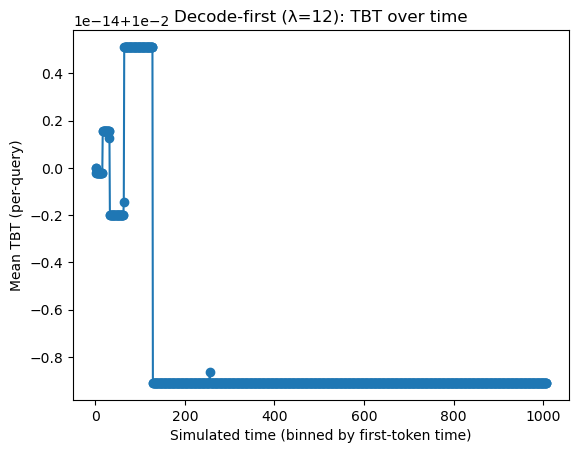

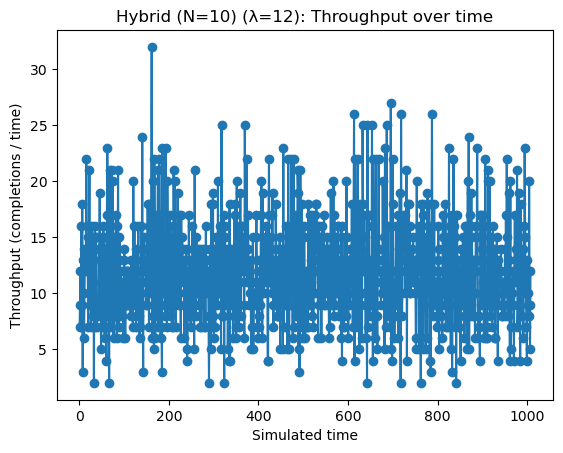

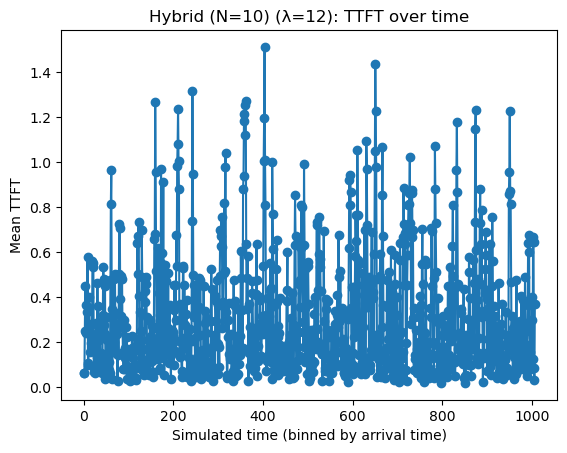

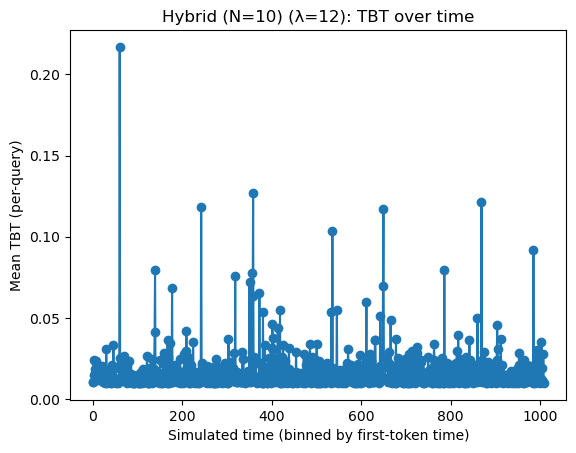

In [27]:
# Time-series plots for the demo (throughput / TTFT / TBT over time)

def bin_series(x_times, values, bin_edges, agg="mean"):
    x_times = np.asarray(x_times, dtype=float)
    values = np.asarray(values, dtype=float)
    mask = np.isfinite(x_times) & np.isfinite(values)
    x_times = x_times[mask]
    values = values[mask]
    inds = np.digitize(x_times, bin_edges) - 1
    m = len(bin_edges) - 1
    out = np.full(m, np.nan, dtype=float)
    for b in range(m):
        v = values[inds == b]
        if len(v) == 0:
            continue
        out[b] = np.mean(v) if agg == "mean" else np.median(v)
    centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    return centers, out

def throughput_over_time(complete_times, bin_edges):
    complete_times = np.asarray(complete_times, dtype=float)
    complete_times = complete_times[np.isfinite(complete_times)]
    counts, _ = np.histogram(complete_times, bins=bin_edges)
    bin_width = float(bin_edges[1] - bin_edges[0])
    centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    return centers, counts / bin_width

def plot_time_series_for_run(title, traces, bin_width=1.0, t_min=None, t_max=None):
    arr = traces["arrival_time"]
    ft = traces["first_token_time"]
    comp = traces["complete_time"]
    ttft = traces["ttft"]
    tbt = traces["mean_tbt"]

    finite_times = np.concatenate([arr[np.isfinite(arr)], comp[np.isfinite(comp)]])
    if finite_times.size == 0:
        raise ValueError("No finite times to plot.")

    if t_min is None:
        t_min = float(np.min(finite_times))
    if t_max is None:
        t_max = float(np.max(finite_times))

    bin_edges = np.arange(t_min, t_max + bin_width, bin_width, dtype=float)

    # Throughput(t): bin by completion times
    x_th, y_th = throughput_over_time(comp, bin_edges)

    # TTFT(t): bin by ARRIVAL times (responsiveness for new users)
    x_ttft, y_ttft = bin_series(arr, ttft, bin_edges, agg="mean")

    # TBT(t): bin by FIRST TOKEN times (streaming once it starts)
    x_tbt, y_tbt = bin_series(ft, tbt, bin_edges, agg="mean")

    plt.figure()
    plt.plot(x_th, y_th, marker="o")
    plt.xlabel("Simulated time")
    plt.ylabel("Throughput (completions / time)")
    plt.title(f"{title}: Throughput over time")
    plt.show()

    plt.figure()
    plt.plot(x_ttft, y_ttft, marker="o")
    plt.xlabel("Simulated time (binned by arrival time)")
    plt.ylabel("Mean TTFT")
    plt.title(f"{title}: TTFT over time")
    plt.show()

    plt.figure()
    plt.plot(x_tbt, y_tbt, marker="o")
    plt.xlabel("Simulated time (binned by first-token time)")
    plt.ylabel("Mean TBT (per-query)")
    plt.title(f"{title}: TBT over time")
    plt.show()

# --- Run one λ for demo time-series ---
lam_demo = 12

runs = [
    ("Prefill-first", PrefillFirstScheduler()),
    ("Decode-first", DecodeFirstScheduler()),
    ("Hybrid (N=10)", HybridEveryNScheduler(10)),
]

for name, sched in runs:
    out = run_one(
        lam=lam_demo,
        scheduler=sched,
        batch_cap=1024,
        c=0.01,
        a=0.0005,
        b0=64,
        max_queries=12000,
        warmup_queries=2000,
        seed=0,
        service_mode="deterministic",
        validation_mm1=False,
        return_traces=True,  # <-- required
    )
    plot_time_series_for_run(f"{name} (λ={lam_demo})", out["_traces"], bin_width=1.0)

## Time-Series Analysis of System Dynamics

While aggregate metrics capture long-run averages, they can obscure important transient effects. To better understand dynamic behavior, we examine time-series plots of throughput, TTFT, and TBT over simulated time. These plots reveal how congestion builds, how schedulers admit new queries, and how smoothly tokens are streamed under different policies, making them particularly useful for qualitative interpretation and live demonstrations.

### End-to-End Latency

End-to-end latency measures the total time from when a query arrives until the full response has been generated. Unlike TTFT or TBT, which isolate specific aspects of user experience, end-to-end latency aggregates all sources of delay: waiting time before prefill, prefill service time, waiting between decode steps, and total decode service time.

At low arrival rates, end-to-end latency is small and similar across all scheduling policies. In this regime, queues are short, the GPU has ample idle capacity, and most queries experience little waiting beyond the intrinsic cost of prefill and decode.

As arrival rate increases, end-to-end latency grows rapidly, but the magnitude and growth rate depend strongly on the scheduling policy:

- **Decode-first scheduling** exhibits the most dramatic increase in end-to-end latency at moderate-to-high arrival rates. The severe growth in TTFT caused by prefill starvation directly translates into large end-to-end delays, since queries spend a long time waiting before any meaningful progress is made. Tail latency (p95) is especially large under this policy, reflecting extreme waiting times for a subset of queries.

- **Prefill-first scheduling** results in substantially lower end-to-end latency for newly arriving queries, particularly in the tail. By ensuring that prefills are completed promptly, this policy prevents queries from being blocked indefinitely at the front of the pipeline. However, because decode progress can be delayed, some increase in end-to-end latency is still observed as load becomes heavy.

- **Hybrid scheduling** again strikes a balance between the two extremes. End-to-end latency under the hybrid policy is significantly lower than under decode-first scheduling while remaining higher than under prefill-first scheduling in some regimes. This reflects its compromise between admitting new work and maintaining decode progress.

An important observation is that end-to-end latency amplifies the effects seen in both TTFT and TBT. Policies that perform poorly on either responsiveness or streaming smoothness tend to exhibit especially poor tail latency when these effects compound. As a result, end-to-end latency provides a holistic view of the cost of scheduling decisions under heavy load.

In the next cell, we present mean and p95 end-to-end latency plots to quantify these effects across arrival rates.


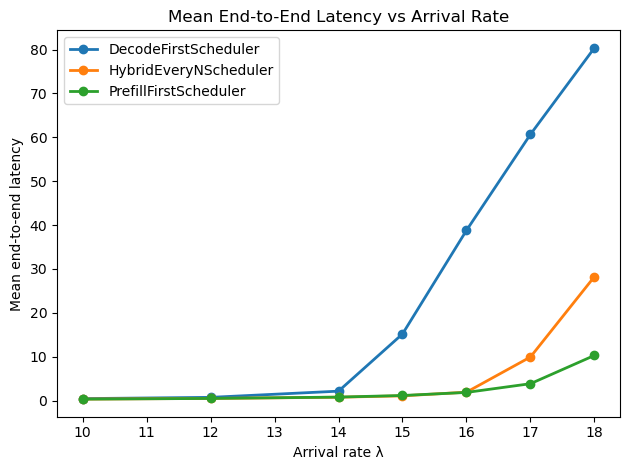

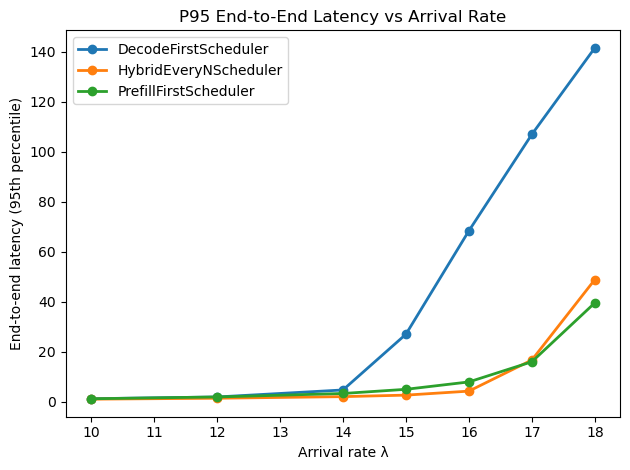

In [29]:
# Analysis Plot: Mean End-to-End Latency vs Arrival Rate
plt.figure()

for sched in agg["scheduler"].unique():
    sub = agg[agg["scheduler"] == sched]
    plt.plot(
        sub["lambda"],
        sub["mean_latency"],
        marker="o",
        linewidth=2,
        label=sched
    )

plt.xlabel("Arrival rate λ")
plt.ylabel("Mean end-to-end latency")
plt.title("Mean End-to-End Latency vs Arrival Rate")
plt.legend()
plt.tight_layout()
plt.show()


# Analysis Plot: P95 End-to-End Latency vs Arrival Rate
plt.figure()

for sched in agg["scheduler"].unique():
    sub = agg[agg["scheduler"] == sched]
    plt.plot(
        sub["lambda"],
        sub["p95_latency"],
        marker="o",
        linewidth=2,
        label=sched
    )

plt.xlabel("Arrival rate λ")
plt.ylabel("End-to-end latency (95th percentile)")
plt.title("P95 End-to-End Latency vs Arrival Rate")
plt.legend()
plt.tight_layout()
plt.show()


### Interpretation of End-to-End Latency Results

The end-to-end latency plots provide a holistic view of system performance by combining all sources of delay: waiting before prefill, prefill service time, waiting between decode steps, and total decode service time. As such, they summarize and amplify the effects observed earlier in the TTFT and TBT analyses.

At low arrival rates (λ = 10–12), both mean and p95 end-to-end latency are small and nearly identical across all scheduling policies. In this lightly loaded regime, queues are short, GPU idle time is abundant, and latency is dominated by intrinsic service time rather than queueing effects.

As arrival rate increases, the divergence between policies becomes pronounced, with a clear nonlinear transition around λ ≈ 14–15:

- **Decode-first scheduling** exhibits a dramatic increase in end-to-end latency. Mean latency grows rapidly once λ exceeds this threshold, and p95 latency increases even more sharply. This behavior is driven primarily by the explosion in TTFT caused by prefill starvation. Because queries spend a long time waiting before their prefill is completed, delays accumulate early in the pipeline and propagate through the entire service process. The large gap between mean and p95 latency highlights severe tail risk, where a subset of queries experiences extremely long delays.

- **Prefill-first scheduling** maintains substantially lower end-to-end latency across the entire range of λ values. By ensuring that new queries are promptly admitted into the decode phase, this policy prevents indefinite blocking at the front of the pipeline. Although decode progress may be slowed under heavy load, the resulting increases in end-to-end latency are much more moderate, particularly in the tail.

- **Hybrid scheduling** again demonstrates intermediate behavior. End-to-end latency under the hybrid policy is significantly lower than under decode-first scheduling, especially in the p95 metric, indicating that occasional prefill opportunities are sufficient to dramatically reduce worst-case delays. However, hybrid latency remains higher than prefill-first in some regimes, reflecting its compromise between admitting new work and maintaining decode progress.

Two key insights emerge from these plots. First, end-to-end latency is highly sensitive to TTFT, especially under heavy load: starvation at the prefill stage dominates all downstream effects. Second, tail latency grows much faster than mean latency, underscoring the importance of evaluating p95 (or higher) percentiles when assessing user experience in congested systems.

Overall, the end-to-end latency results reinforce the central theme of the analysis: scheduling policies that aggressively prioritize decode can severely harm overall user experience under heavy load, while policies that prioritize prefill offer substantially better latency guarantees at the cost of reduced streaming smoothness.


## Conclusions

This project used a discrete-event simulation to study how scheduling policies in an LLM serving system affect throughput, responsiveness, streaming smoothness, and tail latency under increasing load. By explicitly modeling the two-stage structure of LLM inference (prefill and decode), batching, and sequential decode constraints, the simulator captures key dynamics observed in real-world systems.

Several clear conclusions emerge from the analysis:

- **Scheduling choices fundamentally shape user experience.** Policies that prioritize decode work can maintain smooth streaming for ongoing queries but may severely degrade responsiveness for new arrivals under heavy load. Conversely, policies that prioritize prefill protect TTFT and overall latency but can delay decode progress.

- **Prefill starvation is a dominant failure mode.** Under decode-first scheduling, strict prioritization of decode leads to prefill starvation once the system becomes heavily loaded. This causes TTFT and end-to-end latency—especially tail latency—to grow dramatically, even though GPU utilization remains high.

- **Throughput saturation reflects capacity limits, not inefficiency.** Throughput increases approximately linearly with arrival rate at low load and saturates near the system’s effective capacity. Slight declines in throughput under overload are finite-horizon artifacts of instability rather than simulation errors.

- **Hybrid scheduling offers a meaningful compromise.** By periodically allowing prefill work even when decode work exists, the hybrid policy substantially reduces starvation and tail latency while preserving reasonably smooth streaming. Its performance consistently lies between the decode-first and prefill-first extremes.

- **Tail metrics are essential.** Mean performance alone can mask severe congestion effects. P95 TTFT and end-to-end latency reveal large disparities in worst-case user experience, particularly under strict priority scheduling.

The results highlight an inherent trade-off in LLM serving systems: optimizing for streaming smoothness versus optimizing for responsiveness to new users. There is no universally optimal policy; the “best” scheduler depends on service-level objectives and workload characteristics.

### Limitations and Future Work

This study focuses on a simplified single-GPU system with deterministic batch service times and fixed scheduling rules. Several extensions could improve realism and provide further insight, including:
- stochastic service times,
- chunked or partial prefills,
- multi-GPU systems and load balancing,
- adaptive or feedback-driven scheduling policies.

Despite these simplifications, the simulator captures essential queueing and scheduling effects and provides a useful framework for reasoning about performance trade-offs in LLM inference serving.
